In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
#Load Datasets

## load Project Sunroof Data
sr_data = pd.read_csv("data/project-sunroof-census_tract.csv", index_col="region_name")
sr_data = sr_data.rename_axis(index={"region_name": "GEOID"})
sr_data.index = sr_data.index.astype(int)
#print(sr_data.head(5))

#load Energy Equity Project Data
eep_data = pd.read_csv("data/eep_final_data.csv", index_col="GEOID")
eep_data.index = eep_data.index.astype(int)
#print(eep_data.head(5))

#load Justice40 Data
j40_data = pd.read_csv("data/1.0-communities.csv", index_col="Census tract 2010 ID")
j40_data = j40_data.rename(columns={"Census tract 2010 ID": "GEOID"})
j40_data.index = j40_data.index.astype(int)
#print(j40_data.head(5))

#load Opportunity Zone Data
oz_data = pd.read_csv("data/Opportunity_Zone_ExportTable1.csv", index_col="Tract_Boundaries_ID")
oz_data = oz_data.rename(columns={"Tract_Boundaries_ID": "GEOID"})
oz_data.index = oz_data.index.astype(int)
#print(oz_data.head(5))

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_29885/1587828032.py:15: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  j40_data = pd.read_csv("data/1.0-communities.csv", index_col="Census tract 2010 ID")


In [ ]:
#Check datasets for shape
print(sr_data.shape)
print(eep_data.shape)
print(j40_data.shape)
print(sr_geodata.shape) #Missing about 10,000 wHY??
print(eep_geodata.shape)

In [3]:
#Combine data
sr_selected_cols = sr_data[['percent_covered', 'number_of_panels_total', 'number_of_panels_median', 'kw_median', 'kw_total', 
                            'yearly_sunlight_kwh_median', 'yearly_sunlight_kwh_total', 'carbon_offset_metric_tons', 'existing_installs_count']]

eep_selected_cols = eep_data[['STATE_NAME', 'energy_burden', 'num_solar_installers', 'median_income_solar', 'total_pop', 'year_built', 
                              'total_households', 'median_income', 'owner_occupied', 'renter_occupied', 'bipoc_percent', 'community_power_score',  ]]

j40_selected_cols = j40_data[['Total population', 'Percent of individuals < 100% Federal Poverty Line (percentile)', 'PM2.5 in the air (percentile)', 
                              'Current asthma among adults aged greater than or equal to 18 years (percentile)', 'Housing burden (percent) (percentile)', 
                              'Unemployment (percent) (percentile)']]

merged_data = pd.merge(sr_selected_cols, eep_selected_cols, left_index=True, right_index=True)
merged_data = pd.merge(merged_data, j40_selected_cols, left_index=True, right_index=True )

print(merged_data.head(5))

            percent_covered  number_of_panels_total  number_of_panels_median   
1001020100       103.360215                 39080.0                     48.0  \
1001020200       104.472843                 59054.0                     44.0   
1001020300       101.278409                 80364.0                     41.0   
1001020400       101.384451                 94598.0                     54.0   
1001020600       113.555195                 93919.0                     48.0   

            kw_median  kw_total  yearly_sunlight_kwh_median   
1001020100      12.00   9770.00                 14854.40286  \
1001020200      11.00  14763.50                 13564.14519   
1001020300      10.25  20091.00                 12725.93064   
1001020400      13.50  23649.50                 16586.32144   
1001020600      12.00  23479.75                 15360.34045   

            yearly_sunlight_kwh_total  carbon_offset_metric_tons   
1001020100                 12300000.0                7325.568357  \
1001

In [11]:
#Normalize Data

criteria = ['yearly_sunlight_kwh_total', 'owner_occupied', 'community_power_score', 'year_built', 
             'energy_burden', 'Percent of individuals < 100% Federal Poverty Line (percentile)',
             'PM2.5 in the air (percentile)', 'Current asthma among adults aged greater than or equal to 18 years (percentile)',
             'Housing burden (percent) (percentile)', 'Unemployment (percent) (percentile)']

normalized_data = merged_data.copy()

#minmax normalization
for criterion in criteria:
    normalized_data[criterion] = normalized_data[criterion] / (normalized_data[criterion].max() - normalized_data[criterion].min())

#z-score normalization (this assumes the datasets have normal distributions, but do they?)
# for criterion in weights.keys():
#     normalized_data[criterion] = (normalized_data[criterion] - normalized_data[criterion].mean()) / normalized_data[criterion].std()

In [12]:
#MCDA for Feasibility, Impact, Co-Benefits

weights_feasibility = {
    'yearly_sunlight_kwh_total': 0.4,
    'owner_occupied': 0.3,
    'community_power_score': 0.2,
    'year_built': 0.1
}

weights_impact = {
    'yearly_sunlight_kwh_total': 0.4,
    'energy_burden': 0.35,
    'Percent of individuals < 100% Federal Poverty Line (percentile)': 0.25
}

weights_cobenefits = {
    'PM2.5 in the air (percentile)': 0.3,
    'Unemployment (percent) (percentile)': 0.3,
    'Current asthma among adults aged greater than or equal to 18 years (percentile)': 0.2,
    'Housing burden (percent) (percentile)': 0.2
}

mcda_output = pd.DataFrame()

# Perform the weighted sum calculation
mcda_output['feasibility_score'] = (normalized_data[list(weights_feasibility.keys())] * list(weights_feasibility.values())).sum(axis=1)
mcda_output['impact_score'] = (normalized_data[list(weights_impact.keys())] * list(weights_impact.values())).sum(axis=1)
mcda_output['cobenefits_score'] = (normalized_data[list(weights_cobenefits.keys())] * list(weights_cobenefits.values())).sum(axis=1)

# Categorize the scores
# bins = [0, 0.33, 0.67, 1]
labels = ['low', 'med', 'high']
mcda_output['feasibility_potential'] = pd.cut(mcda_output['feasibility_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['impact_potential'] = pd.cut(mcda_output['impact_score'], bins=3, labels=labels, include_lowest=True)
mcda_output['cobenefits_potential'] = pd.cut(mcda_output['cobenefits_score'], bins=3, labels=labels, include_lowest=True)

##Q: How does the binning work? Important to understand the results
print(mcda_output.head)

<bound method NDFrame.head of              feasibility_score  impact_score  cobenefits_score   
1001020100            0.349397      0.183236          0.482677  \
1001020200            0.337906      0.194469          0.614465   
1001020300            0.350945      0.198319          0.523899   
1001020400            0.374460      0.062836          0.399384   
1001020600            0.389296      0.234844          0.649990   
...                        ...           ...               ...   
56025001200           0.403680      0.160816          0.444586   
56025001401           0.420815      0.113482          0.392182   
56025001602           0.389085      0.091810          0.135657   
56025001603           0.446664      0.026206          0.199677   
56025001700           0.423204      0.038513          0.206525   

            feasibility_potential impact_potential cobenefits_potential  
1001020100                    med              low                  med  
1001020200                   

In [13]:
#print
print(mcda_output['feasibility_potential'].value_counts())
print(mcda_output['impact_potential'].value_counts())
print(mcda_output['cobenefits_potential'].value_counts())
#print(mcda_output.loc[mcda_output['potential'] == 'high potential'])

feasibility_potential
med     38310
low      8210
high      775
Name: count, dtype: int64
impact_potential
low     35191
med     12099
high        5
Name: count, dtype: int64
cobenefits_potential
med     27091
high    11907
low      8297
Name: count, dtype: int64


In [6]:
#map data
#load Energy Equity Project geojson for geometry
eep_geodata = gpd.read_file("data/eep_final_simplified.json")

#Extract GEOID and Geometry to join into other datasets later
tract_geoid = eep_geodata[["GEOID", "geometry"]]
tract_geoid = tract_geoid.set_index("GEOID")
tract_geoid.index = tract_geoid.index.astype(int)
print(tract_geoid.head(5))

                                                      geometry
GEOID                                                         
13163960300  POLYGON ((-82.66192 33.12633, -82.66192 33.126...
37109071201  POLYGON ((-80.99344 35.47878, -80.99386 35.471...
25025050200  POLYGON ((-71.04003 42.37865, -71.03907 42.374...
17031230200  POLYGON ((-87.71342 41.91359, -87.71331 41.910...
41047001607  POLYGON ((-122.99032 44.96821, -122.99031 44.9...


Text(0.5, 1.0, 'Co-Benefits Potential by Census Tract')

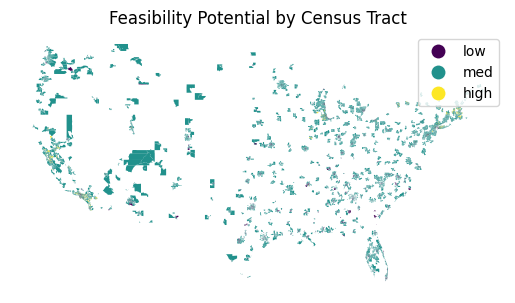

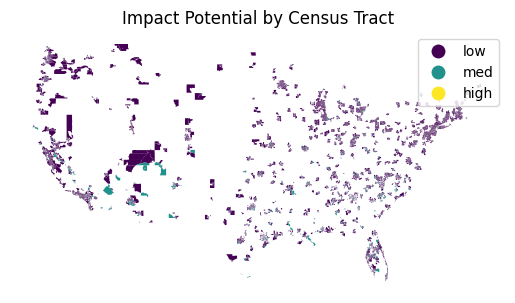

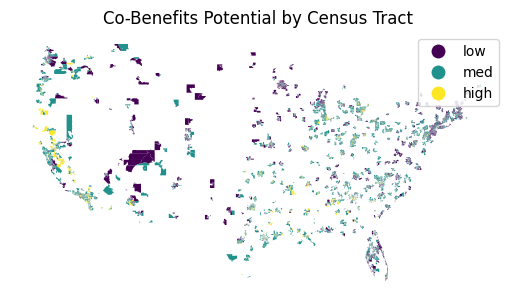

In [17]:
#Merge geometry attributes with normalized data
mcda_geodata = tract_geoid.merge(mcda_output, left_index=True, right_index=True)

#Map potential
feasibility_map = mcda_geodata.plot("feasibility_potential", legend=True, cmap='viridis')
impact_map = mcda_geodata.plot("impact_potential", legend=True, cmap='viridis')
cobenefits_map = mcda_geodata.plot("cobenefits_potential", legend=True, cmap='viridis')

feasibility_map.set_axis_off()
feasibility_map.set_title("Feasibility Potential by Census Tract")

impact_map.set_axis_off()
impact_map.set_title("Impact Potential by Census Tract")

cobenefits_map.set_axis_off()
cobenefits_map.set_title("Co-Benefits Potential by Census Tract")


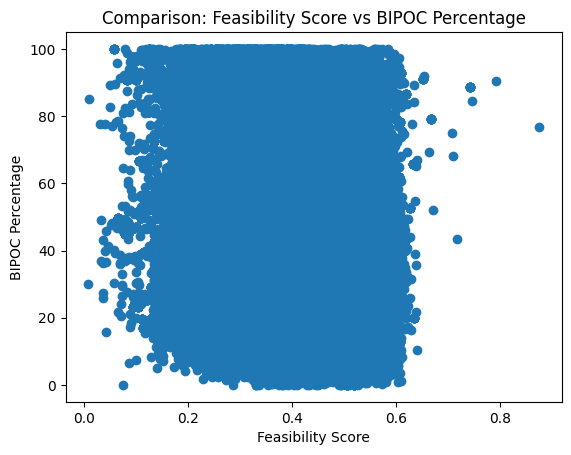

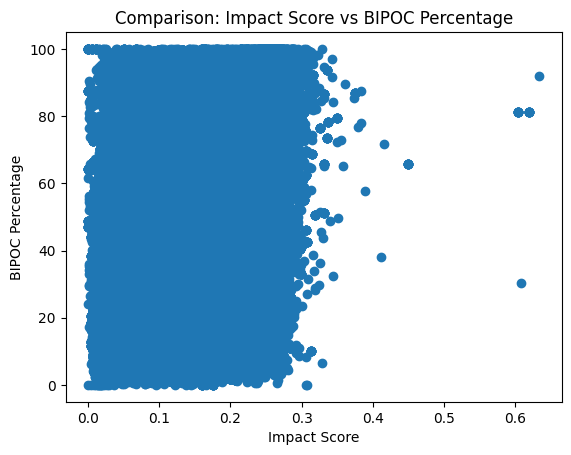

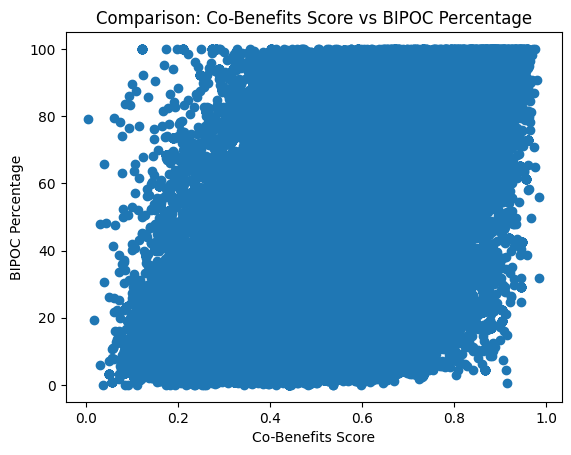

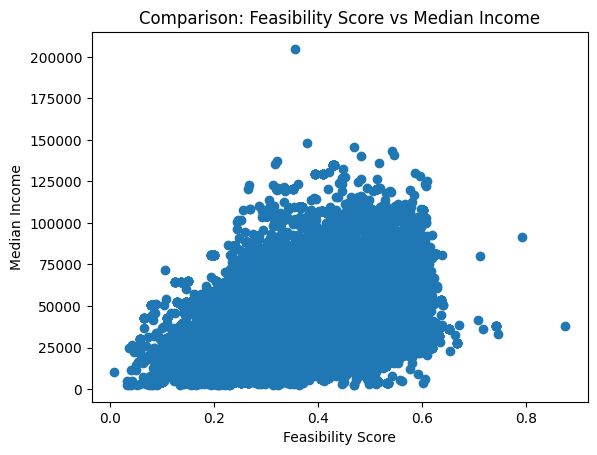

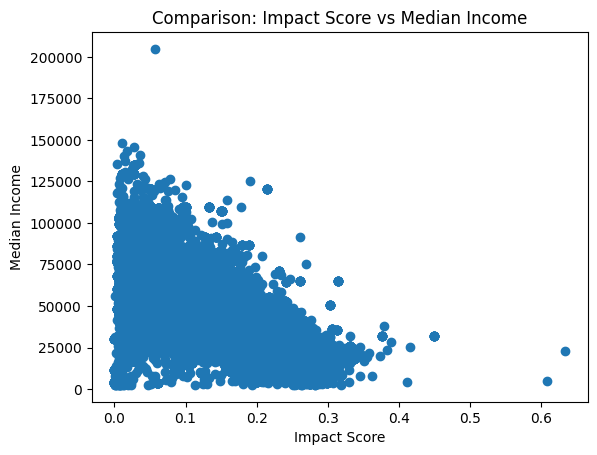

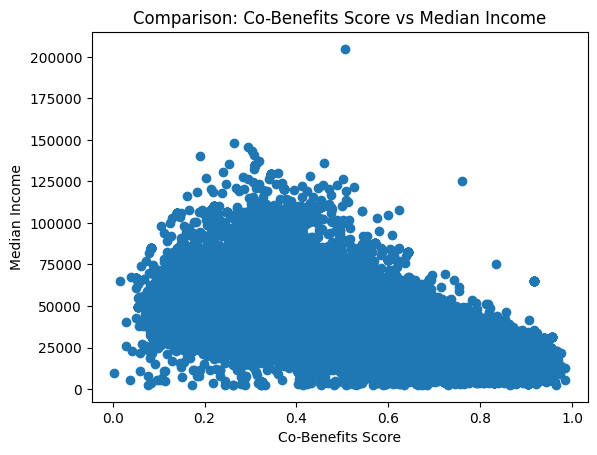

In [30]:
#Compare potential with Income, BIPOC, # of existing installs

# # Merge the mcda output data back into original dataframe
# mcda_data = merged_data.merge(mcda_output, left_index=True, right_index=True)



# Scatter plot of 'feasibility_score' vs 'bipoc_percent'
plt.scatter(merged_data['feasibility_score'], merged_data['bipoc_percent'])
plt.xlabel('Feasibility Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Feasibility Score vs BIPOC Percentage')
plt.show()

plt.scatter(merged_data['impact_score'], merged_data['bipoc_percent'])
plt.xlabel('Impact Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Impact Score vs BIPOC Percentage')
plt.show()

plt.scatter(merged_data['cobenefits_score'], merged_data['bipoc_percent'])
plt.xlabel('Co-Benefits Score')
plt.ylabel('BIPOC Percentage')
plt.title('Comparison: Co-Benefits Score vs BIPOC Percentage')
plt.show()

# Scatter plot of 'feasibility_score' vs 'median_income'
plt.scatter(merged_data['feasibility_score'], merged_data['median_income'])
plt.xlabel('Feasibility Score')
plt.ylabel('Median Income')
plt.title('Comparison: Feasibility Score vs Median Income')
plt.show()

plt.scatter(merged_data['impact_score'], merged_data['median_income'])
plt.xlabel('Impact Score')
plt.ylabel('Median Income')
plt.title('Comparison: Impact Score vs Median Income')
plt.show()

plt.scatter(merged_data['cobenefits_score'], merged_data['median_income'])
plt.xlabel('Co-Benefits Score')
plt.ylabel('Median Income')
plt.title('Comparison: Co-Benefits Score vs Median Income')
plt.show()

